# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# clone and install genepy
# pip install -e genepy

In [3]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [1]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np
from natsort import os_sorted

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

In [3]:
from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# MV411 WT and MYB-dTAG cells co-cultured

SLAMseq with WT and MYB-dTAG MV411 cells co-cultured
<br>12h with drug + 1h 4sU with 0.5$\mu$M VHL (with ERCC spike-in control)
<br>__Processed without alt loci__

In [5]:
project = "MYB_degraded_coculture_v1"

In [7]:
location = "../data/slamseq_"+project+"/" # new data location

## download the data

In [6]:
location = "../data/slamseq_"+project+"/" # new data location
loc = "220526_MP10028_fastq" # transfer AML folder

In [17]:
! mkdir ../$location
! mkdir ../results/slamseq_$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

mkdir: cannot create directory ‘../../data/slamseq_MYB_degron_coculture_v1/’: File exists
mkdir: cannot create directory ‘../results/slamseq_MYB_degron_coculture_v1’: File exists
mkdir: cannot create directory ‘../data/slamseq_MYB_degron_coculture_v1/’: File exists
mkdir: cannot create directory ‘../../data/slamseq_MYB_degron_coculture_v1//fastqs/’: File exists


In [19]:
! gsutil ls gs://transfer-amlproject/$loc/*.fastq.gz

gs://transfer-amlproject/220526_MP10028_fastq/20220526_10_MP10028_S34_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_10_MP10028_S34_R2_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_11_MP10028_S35_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_11_MP10028_S35_R2_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_12_MP10028_S36_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_12_MP10028_S36_R2_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_13_MP10028_S37_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_13_MP10028_S37_R2_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_15_MP10028_S38_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_15_MP10028_S38_R2_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526_16_MP10028_S39_R1_001.fastq.gz
gs://transfer-amlproject/220526_MP10028_fastq/20220526

In [21]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/

Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_report.html...
/ [1/1 files][  1.5 MiB/  1.5 MiB] 100% Done                                    
Operation completed over 1 objects/1.5 MiB.                                      
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_10_MP10028_S34_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_10_MP10028_S34_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_10_MP10028_S34_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_10_MP10028_S34_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_11_MP10028_S35_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_11_MP10028_S35_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220526_MP10028_fastq/Reports/20220526_11_MP10028_S35_R2_001_fastqc.zip...
Copying 

- [76/76 files][ 35.3 MiB/ 35.3 MiB] 100% Done                                  
Operation completed over 76 objects/35.3 MiB.                                    
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc.log...
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc_data.json...
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc_fastqc.txt...
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc_general_stats.txt...
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc_qualimap_bamqc_genome_results.txt...
Copying gs://transfer-amlproject/220526_MP10028_fastq/multiqc_data/multiqc_sources.txt...
/ [6/6 files][  2.3 MiB/  2.3 MiB] 100% Done                                    
Operation completed over 6 objects/2.3 MiB.                                      


In [22]:
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

In [23]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz

add sample names to AML sample tracker google sheet (RNA_tracker_JK)

missing file: __20220526_14_MP10028__ failed initial QC

In [26]:
fastqs = [fastq.split("/")[-1] for fastq in os_sorted(fastqs)]
print(len(fastqs))
# add sample names to AML sample tracker google sheet
for val1, val2 in h.grouped(fastqs, 2):
    print(val1.split("_R")[0])

38
20220526_1_MP10028_S25
20220526_2_MP10028_S26
20220526_3_MP10028_S27
20220526_4_MP10028_S28
20220526_5_MP10028_S29
20220526_6_MP10028_S30
20220526_7_MP10028_S31
20220526_8_MP10028_S32
20220526_9_MP10028_S33
20220526_10_MP10028_S34
20220526_11_MP10028_S35
20220526_12_MP10028_S36
20220526_13_MP10028_S37
20220526_15_MP10028_S38
20220526_16_MP10028_S39
20220526_17_MP10028_S40
20220526_18_MP10028_S41
20220526_19_MP10028_S42
20220526_20_MP10028_S43


In [30]:
# transfer fastqs
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/

Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_11_MP10028_S35_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_8_MP10028_S32_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_2_MP10028_S26_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_17_MP10028_S40_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_1_MP10028_S25_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_6_MP10028_S30_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_11_MP10028_S35_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_5_MP10028_S29_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_17_MP10028_S40_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220526_MP10028_fastq/20220526_15_MP10028_S38_R1_001.fastq.gz...
Copying gs://transfer-amlproject/22

## rename local fastqs

In [9]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs = os_sorted(fastqs)
fastqs

../../data/slamseq_MYB_degraded_coculture_v1/fastqs


['mr571-MV411-DMSO_coculture_12h-r1_R1_001.fastq.gz',
 'mr571-MV411-DMSO_coculture_12h-r1_R1_001.fastq.gz_trimming_report.txt',
 'mr571-MV411-DMSO_coculture_12h-r1_R1_001_unpaired_1.fq.gz',
 'mr571-MV411-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz',
 'mr571-MV411-DMSO_coculture_12h-r1_R2_001.fastq.gz',
 'mr571-MV411-DMSO_coculture_12h-r1_R2_001.fastq.gz_trimming_report.txt',
 'mr571-MV411-DMSO_coculture_12h-r1_R2_001_unpaired_2.fq.gz',
 'mr571-MV411-DMSO_coculture_12h-r1_R2_001_val_2.fq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R1_001.fastq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R1_001.fastq.gz_trimming_report.txt',
 'mr572-MV411-DMSO_coculture_12h-r2_R1_001_unpaired_1.fq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R1_001_val_1.fq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R2_001.fastq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R2_001.fastq.gz_trimming_report.txt',
 'mr572-MV411-DMSO_coculture_12h-r2_R2_001_unpaired_2.fq.gz',
 'mr572-MV411-DMSO_coculture_12h-r2_R2_001_val_2.fq.gz',
 'mr573-MV41

In [34]:
fastqs[::2]

['20220526_1_MP10028_S25_R1_001.fastq.gz',
 '20220526_2_MP10028_S26_R1_001.fastq.gz',
 '20220526_3_MP10028_S27_R1_001.fastq.gz',
 '20220526_4_MP10028_S28_R1_001.fastq.gz',
 '20220526_5_MP10028_S29_R1_001.fastq.gz',
 '20220526_6_MP10028_S30_R1_001.fastq.gz',
 '20220526_7_MP10028_S31_R1_001.fastq.gz',
 '20220526_8_MP10028_S32_R1_001.fastq.gz',
 '20220526_9_MP10028_S33_R1_001.fastq.gz',
 '20220526_10_MP10028_S34_R1_001.fastq.gz',
 '20220526_11_MP10028_S35_R1_001.fastq.gz',
 '20220526_12_MP10028_S36_R1_001.fastq.gz',
 '20220526_13_MP10028_S37_R1_001.fastq.gz',
 '20220526_15_MP10028_S38_R1_001.fastq.gz',
 '20220526_16_MP10028_S39_R1_001.fastq.gz',
 '20220526_17_MP10028_S40_R1_001.fastq.gz',
 '20220526_18_MP10028_S41_R1_001.fastq.gz',
 '20220526_19_MP10028_S42_R1_001.fastq.gz',
 '20220526_20_MP10028_S43_R1_001.fastq.gz']

In [35]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [38]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info = sample_info.iloc[:int(len(fastqs)/2),]
print(sample_info.shape)

(19, 2)


In [40]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

# Processing

In [7]:
project

'MYB_degraded_coculture_v1'

In [8]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder/*fastq.gz
fastqs[::2]

../../data/slamseq_MYB_degraded_coculture_v1/fastqs


['../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr571-MV411-DMSO_coculture_12h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr572-MV411-DMSO_coculture_12h-r2_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr573-MV411-DMSO_coculture_12h-r3_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr574-MV411-DMSO_coculture_12h-r4_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr575-MV411-DMSO_coculture_12h-r5_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr576-MV411-VHL_coculture_12h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr577-MV411-VHL_coculture_12h-r2_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr578-MV411-VHL_coculture_12h-r3_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr579-MV411-VHL_coculture_12h-r4_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_coculture_v1/fas

## trim_galore

In [49]:
for val1, val2 in h.grouped(fastqs, 2):
    print(os.path.basename(val1))

mr571-MV411-DMSO_coculture_12h-r1_R1_001.fastq.gz
mr572-MV411-DMSO_coculture_12h-r2_R1_001.fastq.gz
mr573-MV411-DMSO_coculture_12h-r3_R1_001.fastq.gz
mr574-MV411-DMSO_coculture_12h-r4_R1_001.fastq.gz
mr575-MV411-DMSO_coculture_12h-r5_R1_001.fastq.gz
mr576-MV411-VHL_coculture_12h-r1_R1_001.fastq.gz
mr577-MV411-VHL_coculture_12h-r2_R1_001.fastq.gz
mr578-MV411-VHL_coculture_12h-r3_R1_001.fastq.gz
mr579-MV411-VHL_coculture_12h-r4_R1_001.fastq.gz
mr580-MV411-VHL_coculture_12h-r5_R1_001.fastq.gz
mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_R1_001.fastq.gz
mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_R1_001.fastq.gz
mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_R1_001.fastq.gz
mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_R1_001.fastq.gz
mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_R1_001.fastq.gz
mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_R1_001.fastq.gz
mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_R1_001.fastq.gz
mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_R1_001.fastq.gz
mr589-MV411-MYB-dTAG-VHL_coculture_12

In [50]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs, 2)], 2)

CPU times: user 816 ms, sys: 364 ms, total: 1.18 s
Wall time: 9h 21min 16s


['pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\npigz 2.6\n',
 'pigz 2.6\n']

## slamdunk

install slamdunk & dependencies if needed (see above)

In [51]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [52]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [53]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

PySam warning can be ignored.
<br>[GitHub issue: [E::idx_find_and_load] Could not retrieve index file" when AlignmentFile](https://github.com/pysam-developers/pysam/issues/939)

In [11]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [12]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [13]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

In [14]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_MYB_degraded_coculture_v1/res'

In [58]:
%%time

# print call
print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_coculture_v1/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr571-MV411-DMSO_coculture_12h-r1 ../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr571-MV411-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_coculture_v1/fastqs/mr571-MV411-DMSO_coculture_12h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 171 µs


In [62]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 364 ms, sys: 172 ms, total: 536 ms
Wall time: 4h 14min 48s


['[MAIN] NextGenMap 0.5.5\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-06-21.13:26:42\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_coculture_v1/res/map/mr571-MV411-DMSO_coculture_12h-r1_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_

In [15]:
for val1, val2 in h.grouped(fastq_full[10:14]+fastq_full[16:18], 2): print(os.path.basename(val1))

mr576-MV411-VHL_coculture_12h-r1_R1_001_val_1.fq.gz
mr577-MV411-VHL_coculture_12h-r2_R1_001_val_1.fq.gz
mr579-MV411-VHL_coculture_12h-r4_R1_001_val_1.fq.gz


In [17]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[10:12], 2)], 2)

CPU times: user 428 ms, sys: 120 ms, total: 548 ms
Wall time: 4h 9min 42s


['[MAIN] NextGenMap 0.5.5\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-06-22.21:09:03\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_coculture_v1/res/map/mr576-MV411-VHL_coculture_12h-r1_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_d

In [60]:
for val1, val2 in h.grouped(fastq_full, 2): print(os.path.basename(val1))

mr571-MV411-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz
mr572-MV411-DMSO_coculture_12h-r2_R1_001_val_1.fq.gz
mr573-MV411-DMSO_coculture_12h-r3_R1_001_val_1.fq.gz
mr574-MV411-DMSO_coculture_12h-r4_R1_001_val_1.fq.gz
mr575-MV411-DMSO_coculture_12h-r5_R1_001_val_1.fq.gz
mr576-MV411-VHL_coculture_12h-r1_R1_001_val_1.fq.gz
mr577-MV411-VHL_coculture_12h-r2_R1_001_val_1.fq.gz
mr578-MV411-VHL_coculture_12h-r3_R1_001_val_1.fq.gz
mr579-MV411-VHL_coculture_12h-r4_R1_001_val_1.fq.gz
mr580-MV411-VHL_coculture_12h-r5_R1_001_val_1.fq.gz
mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz
mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_R1_001_val_1.fq.gz
mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_R1_001_val_1.fq.gz
mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_R1_001_val_1.fq.gz
mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_R1_001_val_1.fq.gz
mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_R1_001_val_1.fq.gz
mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_R1_001_val_1.fq.gz
mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_R1

## save the data to the bucket

In [10]:
project

'MYB_degraded_coculture_v1'

In [11]:
! ls ../../data/slamseq_$project

fastqs	res


* save fastqs to bucket
* save processed res to bucket
* remove processed fastqs from local

In [ ]:
! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

## remove processed fastqs

check all fastq files are uploaded

In [20]:
fastqs_bucket = ! gsutil ls gs://amlproject/RNA/slamseq/$project/fastqs/
fastqs_bucket = [os.path.basename(fastq) for fastq in fastqs_bucket]

fastqs = ! ls $fastq_folder
fastqs = [os.path.basename(fastq) for fastq in fastqs]

if not all(fastq in fastqs_bucket for fastq in fastqs):
    raise ValueError("All fastq files not uploaded to bucket.")

In [22]:
res_folder = "../../data/"+"slamseq_"+project+"/res"
count_files = ! ls $res_folder/count/*tsv
processed_samples = [f.split("/")[-1].split("-")[0] for f in count_files]

In [24]:
fastq_files = ! ls $fastq_folder
fastq_files = [fastq_folder+"/"+f for f in fastq_files]
fastqs_rm = [fastq for fastq in fastq_files if any(sample in fastq for sample in processed_samples)]
print(len(fastqs_rm)/8)

19.0


In [25]:
for f in fastqs_rm:
    os.remove(f)

## Recreate RNA matrix from slamdunk's tccount files

### get counts over ERCC genome

In [26]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [27]:
print(len(files))
files

19


['mr571-MV411-DMSO_coculture_12h-r1_filtered.bam',
 'mr572-MV411-DMSO_coculture_12h-r2_filtered.bam',
 'mr573-MV411-DMSO_coculture_12h-r3_filtered.bam',
 'mr574-MV411-DMSO_coculture_12h-r4_filtered.bam',
 'mr575-MV411-DMSO_coculture_12h-r5_filtered.bam',
 'mr576-MV411-VHL_coculture_12h-r1_filtered.bam',
 'mr577-MV411-VHL_coculture_12h-r2_filtered.bam',
 'mr578-MV411-VHL_coculture_12h-r3_filtered.bam',
 'mr579-MV411-VHL_coculture_12h-r4_filtered.bam',
 'mr580-MV411-VHL_coculture_12h-r5_filtered.bam',
 'mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_filtered.bam',
 'mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_filtered.bam',
 'mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_filtered.bam',
 'mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_filtered.bam',
 'mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_filtered.bam',
 'mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_filtered.bam',
 'mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_filtered.bam',
 'mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_filtered.bam',
 'mr589-MV411-MYB-d

In [29]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [31]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr571-MV411-DMSO_coculture_12h-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150

In [32]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['', '']

In [33]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['', '']

In [36]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

19


In [37]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [39]:
print(df.shape)
df.iloc[:2]

(92, 19)


,ERCC_mr571-MV411-DMSO_coculture_12h-r1_filtered.bam,ERCC_mr572-MV411-DMSO_coculture_12h-r2_filtered.bam,ERCC_mr573-MV411-DMSO_coculture_12h-r3_filtered.bam,ERCC_mr574-MV411-DMSO_coculture_12h-r4_filtered.bam,ERCC_mr575-MV411-DMSO_coculture_12h-r5_filtered.bam,ERCC_mr576-MV411-VHL_coculture_12h-r1_filtered.bam,ERCC_mr577-MV411-VHL_coculture_12h-r2_filtered.bam,ERCC_mr578-MV411-VHL_coculture_12h-r3_filtered.bam,ERCC_mr579-MV411-VHL_coculture_12h-r4_filtered.bam,ERCC_mr580-MV411-VHL_coculture_12h-r5_filtered.bam,ERCC_mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_filtered.bam,ERCC_mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_filtered.bam,ERCC_mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_filtered.bam,ERCC_mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_filtered.bam,ERCC_mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_filtered.bam,ERCC_mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_filtered.bam,ERCC_mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_filtered.bam,ERCC_mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_filtered.bam,ERCC_mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_filtered.bam
ERCC-00002,53683.218095,52974.509056,50074.010436,37472.060115,48849.293269,42212.129187,73044.988626,53828.882353,43545.977165,52834.806268,55105.484330,42787.013346,44797.333333,43652.748811,55919.558627,43329.444976,32358.905263,68241.846154,53148.351377
ERCC-00003,8094.835443,7520.690065,7002.001053,7148.678762,7027.000000,6785.163309,12346.822467,6994.958246,6936.847872,8339.302204,9717.495327,7761.297155,8303.587924,5945.741416,11689.672521,7434.288421,5429.046154,9015.001036,8812.946225


__fill in project manually__

In [40]:
project

'MYB_degraded_coculture_v1'

In [41]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
print(len(totalcounts))
totalcounts

19


[116115122,
 122557909,
 94060062,
 106222495,
 97298474,
 122370456,
 154707388,
 113054292,
 105815356,
 120532566,
 113496159,
 116067712,
 135090114,
 115925905,
 131485425,
 102826143,
 78880188,
 105131087,
 124090894]

In [42]:
samples = ! ls ../../data/slamseq_$project/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

19


['mr571-MV411-DMSO_coculture_12h-r1',
 'mr572-MV411-DMSO_coculture_12h-r2',
 'mr573-MV411-DMSO_coculture_12h-r3',
 'mr574-MV411-DMSO_coculture_12h-r4',
 'mr575-MV411-DMSO_coculture_12h-r5',
 'mr576-MV411-VHL_coculture_12h-r1',
 'mr577-MV411-VHL_coculture_12h-r2',
 'mr578-MV411-VHL_coculture_12h-r3',
 'mr579-MV411-VHL_coculture_12h-r4',
 'mr580-MV411-VHL_coculture_12h-r5',
 'mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1',
 'mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2',
 'mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3',
 'mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4',
 'mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1',
 'mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2',
 'mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3',
 'mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4',
 'mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5']

In [43]:
pd.Series(totalcounts, index=samples)

mr571-MV411-DMSO_coculture_12h-r1             116115122
mr572-MV411-DMSO_coculture_12h-r2             122557909
mr573-MV411-DMSO_coculture_12h-r3              94060062
mr574-MV411-DMSO_coculture_12h-r4             106222495
mr575-MV411-DMSO_coculture_12h-r5              97298474
mr576-MV411-VHL_coculture_12h-r1              122370456
mr577-MV411-VHL_coculture_12h-r2              154707388
mr578-MV411-VHL_coculture_12h-r3              113054292
mr579-MV411-VHL_coculture_12h-r4              105815356
mr580-MV411-VHL_coculture_12h-r5              120532566
mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1    113496159
mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2    116067712
mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3    135090114
mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4    115925905
mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1     131485425
mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2     102826143
mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3      78880188
mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4     10

In [44]:
# add total counts to csv series
totalcounts_csv = pd.Series(totalcounts, index=samples)
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

calc pseudocounts / scaling factors

In [45]:
# column avg * 10,000 / total column counts
# how much ERCC / reads per sample
res = 10000*df.mean()/totalcounts

In [46]:
res

ERCC_mr571-MV411-DMSO_coculture_12h-r1_filtered.bam             0.262719
ERCC_mr572-MV411-DMSO_coculture_12h-r2_filtered.bam             0.255045
ERCC_mr573-MV411-DMSO_coculture_12h-r3_filtered.bam             0.359446
ERCC_mr574-MV411-DMSO_coculture_12h-r4_filtered.bam             0.244661
ERCC_mr575-MV411-DMSO_coculture_12h-r5_filtered.bam             0.307137
ERCC_mr576-MV411-VHL_coculture_12h-r1_filtered.bam              0.218961
ERCC_mr577-MV411-VHL_coculture_12h-r2_filtered.bam              0.313618
ERCC_mr578-MV411-VHL_coculture_12h-r3_filtered.bam              0.293663
ERCC_mr579-MV411-VHL_coculture_12h-r4_filtered.bam              0.254574
ERCC_mr580-MV411-VHL_coculture_12h-r5_filtered.bam              0.272461
ERCC_mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_filtered.bam    0.339397
ERCC_mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_filtered.bam    0.252033
ERCC_mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_filtered.bam    0.214111
ERCC_mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_fil

In [47]:
print(np.percentile(res.values, [0,25,50,75,100]))

[0.21411078 0.24834679 0.27246068 0.30422972 0.4322698 ]


In [48]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

Creating output directory: ../results/slamseq_MYB_degraded_coculture_v1/plots/


### calc ERCC scaling factors

In [60]:
from natsort import natsorted, ns
from collections import Counter

In [57]:
res.keys()[0].split("-", 1)[1].split("-r")[0]

'MV411-DMSO_coculture_12h'

In [58]:
[r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

['MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h']

mean over replicates
<br>take values for each replicate and get average scaling factor

In [66]:
# replicates per condition
reps = [r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("-", 1)[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("-", 1)[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

MV411-DMSO_coculture_12h: [0.2858014413967712, 0.042544170285098735]
MV411-VHL_coculture_12h: [0.27065517304449116, 0.032586241776154684]
MV411-MYB-dTAG-DMSO_coculture_12h: [0.25907561021281117, 0.04828196291568034]
MV411-MYB-dTAG-VHL_coculture_12h: [0.3102531161060759, 0.06455513754649658]


count distribution of ERCC
* linear vs non-linear distributions
* shows the highest pseudo-RNAs and lowest concentrations are both adequately represented on the curve (should be linear)

[0.21411078 0.24834679 0.27246068 0.30422972 0.4322698 ]


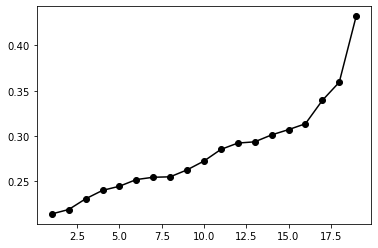

In [72]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [73]:
# df of DMSO vs treatment for each condition
d = pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments'] = d.index
d

,ERCC pseudo-counts,var,Experiments
MV411-DMSO_coculture_12h,0.285801,0.042544,MV411-DMSO_coculture_12h
MV411-VHL_coculture_12h,0.270655,0.032586,MV411-VHL_coculture_12h
MV411-MYB-dTAG-DMSO_coculture_12h,0.259076,0.048282,MV411-MYB-dTAG-DMSO_coculture_12h
MV411-MYB-dTAG-VHL_coculture_12h,0.310253,0.064555,MV411-MYB-dTAG-VHL_coculture_12h


ERCC scaling factors (measures ERCC counts)
* treatment vs DMSO should be different
* &uarr; ERCC factor = &darr; transcripts
* protein level in treatment < DMSO: more ERCC transcripts in treatment than DMSO (less RNA transcripts)
* scaling factors: treatment > DMSO - ERCC counts/scaling factors in treatment should be higher
* scaling factor of control conditions should be similar

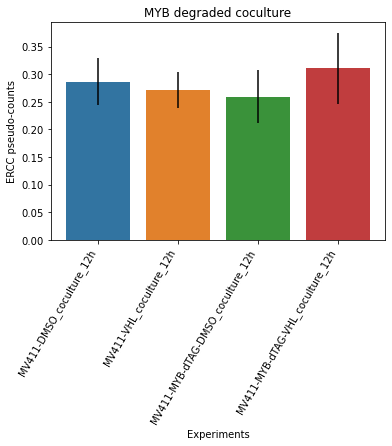

Saved to ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_scaling_fact_with_conf.pdf


In [76]:
version = project.replace("_", " ").split(" ")[-1]
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

__save average ERCC scaling factors__

In [78]:
d

,ERCC pseudo-counts,var,Experiments
MV411-DMSO_coculture_12h,0.285801,0.042544,MV411-DMSO_coculture_12h
MV411-VHL_coculture_12h,0.270655,0.032586,MV411-VHL_coculture_12h
MV411-MYB-dTAG-DMSO_coculture_12h,0.259076,0.048282,MV411-MYB-dTAG-DMSO_coculture_12h
MV411-MYB-dTAG-VHL_coculture_12h,0.310253,0.064555,MV411-MYB-dTAG-VHL_coculture_12h


In [79]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

## save the data to bucket

In [80]:
project

'MYB_degraded_coculture_v1'

In [81]:
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr571-MV411-DMSO_coculture_12h-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr572-MV411-DMSO_coculture_12h-r2_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr571-MV411-DMSO_coculture_12h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr572-MV411-DMSO_coculture_12h-r2_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr573-MV411-DMSO_coculture_12h-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/ERCC_mr573-MV411-DMSO_coculture_12h-r3_filtered.bam.bed [Content-Type=application/octet-str

Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr573-MV411-DMSO_coculture_12h-r3_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr573-MV411-DMSO_coculture_12h-r3_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr574-MV411-DMSO_coculture_12h-r4_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr574-MV411-DMSO_coculture_12h-r4_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr574-MV411-DMSO_coculture_12h-r4_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/filter/mr575-MV411-DMSO_coculture_12h-r5_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/

Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr574-MV411-DMSO_coculture_12h-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr574-MV411-DMSO_coculture_12h-r4_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr574-MV411-DMSO_coculture_12h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr574-MV411-DMSO_coculture_12h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr575-MV411-DMSO_coculture_12h-r5_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_coculture_v1/res/count/mr575-MV411-DMSO_coculture_12h-r5_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## make count files

In [82]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_coculture_v1/res/count/


In [83]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

In [84]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 19 files:dict_keys(['mr571-MV411-DMSO_coculture_12h-r1_tcount', 'mr572-MV411-DMSO_coculture_12h-r2_tcount', 'mr573-MV411-DMSO_coculture_12h-r3_tcount', 'mr574-MV411-DMSO_coculture_12h-r4_tcount', 'mr575-MV411-DMSO_coculture_12h-r5_tcount', 'mr576-MV411-VHL_coculture_12h-r1_tcount', 'mr577-MV411-VHL_coculture_12h-r2_tcount', 'mr578-MV411-VHL_coculture_12h-r3_tcount', 'mr579-MV411-VHL_coculture_12h-r4_tcount', 'mr580-MV411-VHL_coculture_12h-r5_tcount', 'mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount', 'mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount', 'mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount', 'mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount', 'mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount', 'mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount', 'mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount', 'mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount', 'mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount'])
mr571-MV411-DMSO_coculture_12h-r1
mr572-MV411-DMSO_coculture_12h-r

check for duplicate gene rows

In [85]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [86]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
15955 rows | 15920 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
15955 rows | 15920 unique genes
Summing of duplicate gene rows.


## make density plot

In [87]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_MYB_degraded_coculture_v1/


In [88]:
# sort cols
col = tccounts.columns.tolist()
col.sort()
tccounts = tccounts[col]

In [89]:
# sort cols
col = readcounts.columns.tolist()
col.sort()
readcounts = readcounts[col]

In [90]:
print(readcounts.shape)
readcounts.iloc[:2]

(15920, 19)


,mr571-MV411-DMSO_coculture_12h-r1_tcount,mr572-MV411-DMSO_coculture_12h-r2_tcount,mr573-MV411-DMSO_coculture_12h-r3_tcount,mr574-MV411-DMSO_coculture_12h-r4_tcount,mr575-MV411-DMSO_coculture_12h-r5_tcount,mr576-MV411-VHL_coculture_12h-r1_tcount,mr577-MV411-VHL_coculture_12h-r2_tcount,mr578-MV411-VHL_coculture_12h-r3_tcount,mr579-MV411-VHL_coculture_12h-r4_tcount,mr580-MV411-VHL_coculture_12h-r5_tcount,mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount,mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount,mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount,mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount,mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount,mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount,mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount,mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount,mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount
NAT1,364,333,370,387,269,352,438,211,350,333,389,397,441,294,462,342,207,531,367
AAMP,531,542,677,505,402,479,656,572,450,571,593,528,500,471,484,363,252,604,431


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

15320


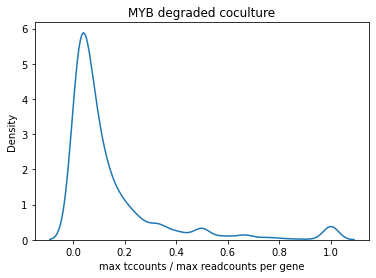

In [91]:
# what is the average of highly transcribed genes?
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [93]:
# median or average across replicates t -> c converted
np.median(a)

0.07142857142857142

In [94]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_MYB_degraded_coculture_v1/MYB_degraded_coculture_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_MYB_degraded_coculture_v1/MYB_degraded_coculture_v1_0_5_tccounts.csv


## make more dfs (mean, median, etc.)

In [95]:
readcounts.iloc[:1]

,mr571-MV411-DMSO_coculture_12h-r1_tcount,mr572-MV411-DMSO_coculture_12h-r2_tcount,mr573-MV411-DMSO_coculture_12h-r3_tcount,mr574-MV411-DMSO_coculture_12h-r4_tcount,mr575-MV411-DMSO_coculture_12h-r5_tcount,mr576-MV411-VHL_coculture_12h-r1_tcount,mr577-MV411-VHL_coculture_12h-r2_tcount,mr578-MV411-VHL_coculture_12h-r3_tcount,mr579-MV411-VHL_coculture_12h-r4_tcount,mr580-MV411-VHL_coculture_12h-r5_tcount,mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount,mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount,mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount,mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount,mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount,mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount,mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount,mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount,mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount
NAT1,364,333,370,387,269,352,438,211,350,333,389,397,441,294,462,342,207,531,367


In [107]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("-", 1)[1].split("_")[0] +": "+ str(readcounts[column].idxmax()) 
          +" ("+str(readcounts[column].max())+")")

Genes with highest read counts per sample.
MV411-DMSO: RPL13AP5 (191608)
MV411-DMSO: RPL13AP5 (197049)
MV411-DMSO: RPL13AP5 (195276)
MV411-DMSO: RPL13AP5 (148147)
MV411-DMSO: RPL13AP5 (145457)
MV411-VHL: RPL13AP5 (185155)
MV411-VHL: RPL13AP5 (197365)
MV411-VHL: RPL13AP5 (163148)
MV411-VHL: RPL13AP5 (158894)
MV411-VHL: RPL13AP5 (195446)
MV411-MYB-dTAG-DMSO: RPL13AP5 (160091)
MV411-MYB-dTAG-DMSO: RPL13AP5 (152304)
MV411-MYB-dTAG-DMSO: RPL13AP5 (162997)
MV411-MYB-dTAG-DMSO: RPL13AP5 (161979)
MV411-MYB-dTAG-VHL: RPL13AP5 (165279)
MV411-MYB-dTAG-VHL: RPL13AP5 (146304)
MV411-MYB-dTAG-VHL: RPL13AP5 (111772)
MV411-MYB-dTAG-VHL: RPL13AP5 (261141)
MV411-MYB-dTAG-VHL: RPL13AP5 (157231)


In [110]:
print(set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))

{'MV411-DMSO_coculture_12h', 'MV411-VHL_coculture_12h', 'MV411-MYB-dTAG-VHL_coculture_12h', 'MV411-MYB-dTAG-DMSO_coculture_12h'}
MV411-DMSO_coculture_12h


['MV411-DMSO_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h']

In [111]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO_coculture_12h
MV411-VHL_coculture_12h
MV411-MYB-dTAG-DMSO_coculture_12h
MV411-MYB-dTAG-VHL_coculture_12h


In [112]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO_coculture_12h
MV411-VHL_coculture_12h
MV411-MYB-dTAG-DMSO_coculture_12h
MV411-MYB-dTAG-VHL_coculture_12h


In [113]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr571-MV411-DMSO_coculture_12h-r1_tcount,mr572-MV411-DMSO_coculture_12h-r2_tcount,mr573-MV411-DMSO_coculture_12h-r3_tcount,mr574-MV411-DMSO_coculture_12h-r4_tcount,mr575-MV411-DMSO_coculture_12h-r5_tcount,mr576-MV411-VHL_coculture_12h-r1_tcount,mr577-MV411-VHL_coculture_12h-r2_tcount,mr578-MV411-VHL_coculture_12h-r3_tcount,mr579-MV411-VHL_coculture_12h-r4_tcount,mr580-MV411-VHL_coculture_12h-r5_tcount,mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount,mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount,mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount,mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount,mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount,mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount,mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount,mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount,mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount
NAT1,0.054945,0.051051,0.021622,0.031008,0.078067,0.065341,0.038813,0.047393,0.045714,0.063063,0.061697,0.055416,0.061224,0.040816,0.088745,0.076023,0.067633,0.052731,0.073569
AAMP,0.013183,0.014760,0.020679,0.011881,0.004975,0.012526,0.015244,0.034965,0.013333,0.019264,0.013491,0.011364,0.014000,0.008493,0.035124,0.013774,0.027778,0.023179,0.034803


In [114]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_MYB_degraded_coculture_v1/MYB_degraded_coculture_v1_0_5_tccounts_per_readcounts.csv


## look at similarity across replicates

In [124]:
# conditions
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h']

### save plots to pdf

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_similarity_replicates_sorted_tccounts.pdf


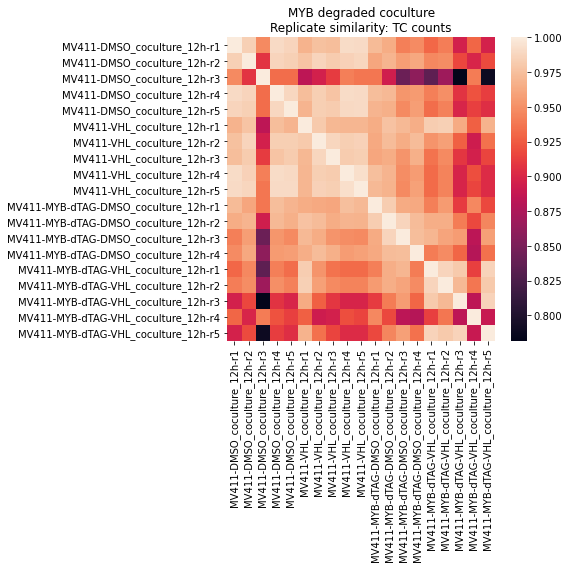

In [125]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(),
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_similarity_replicates_sorted_readcounts.pdf


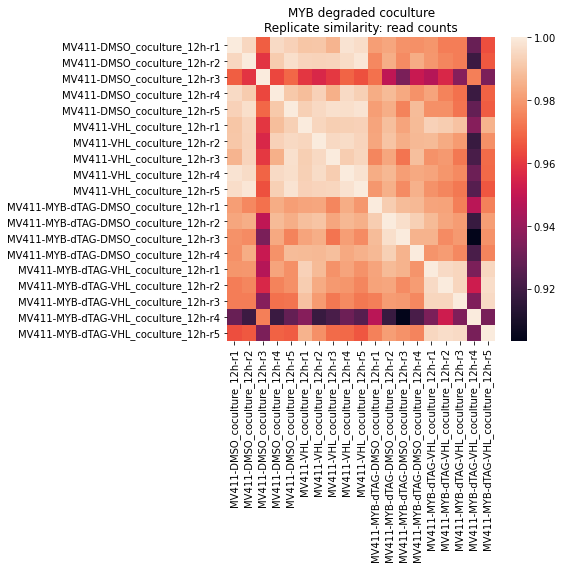

In [126]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax) #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESEQ Analaysis

In [127]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_MYB_degraded_coculture_v1/


In [128]:
readcounts.iloc[:1]

,mr571-MV411-DMSO_coculture_12h-r1_tcount,mr572-MV411-DMSO_coculture_12h-r2_tcount,mr573-MV411-DMSO_coculture_12h-r3_tcount,mr574-MV411-DMSO_coculture_12h-r4_tcount,mr575-MV411-DMSO_coculture_12h-r5_tcount,mr576-MV411-VHL_coculture_12h-r1_tcount,mr577-MV411-VHL_coculture_12h-r2_tcount,mr578-MV411-VHL_coculture_12h-r3_tcount,mr579-MV411-VHL_coculture_12h-r4_tcount,mr580-MV411-VHL_coculture_12h-r5_tcount,mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount,mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount,mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount,mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount,mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount,mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount,mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount,mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount,mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount
NAT1,364,333,370,387,269,352,438,211,350,333,389,397,441,294,462,342,207,531,367


In [129]:
# make genes col
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [130]:
readcounts.iloc[:1]

,mr571-MV411-DMSO_coculture_12h-r1_tcount,mr572-MV411-DMSO_coculture_12h-r2_tcount,mr573-MV411-DMSO_coculture_12h-r3_tcount,mr574-MV411-DMSO_coculture_12h-r4_tcount,mr575-MV411-DMSO_coculture_12h-r5_tcount,mr576-MV411-VHL_coculture_12h-r1_tcount,mr577-MV411-VHL_coculture_12h-r2_tcount,mr578-MV411-VHL_coculture_12h-r3_tcount,mr579-MV411-VHL_coculture_12h-r4_tcount,mr580-MV411-VHL_coculture_12h-r5_tcount,mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount,mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount,mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount,mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount,mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount,mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount,mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount,mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount,mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_tcount,genes
0,364,333,370,387,269,352,438,211,350,333,389,397,441,294,462,342,207,531,367,NAT1


__Exclude replicates__
* MV411-DMSO_coculture_12h rep 3

__ERCC normalization__
* MV411 - no
* MV411-MYB-dTAG - no

In [178]:
cols

Index(['mr571-MV411-DMSO_coculture_12h-r1_tcount',
       'mr572-MV411-DMSO_coculture_12h-r2_tcount',
       'mr573-MV411-DMSO_coculture_12h-r3_tcount',
       'mr574-MV411-DMSO_coculture_12h-r4_tcount',
       'mr575-MV411-DMSO_coculture_12h-r5_tcount',
       'mr576-MV411-VHL_coculture_12h-r1_tcount',
       'mr577-MV411-VHL_coculture_12h-r2_tcount',
       'mr578-MV411-VHL_coculture_12h-r3_tcount',
       'mr579-MV411-VHL_coculture_12h-r4_tcount',
       'mr580-MV411-VHL_coculture_12h-r5_tcount',
       'mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_tcount',
       'mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_tcount',
       'mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_tcount',
       'mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_tcount',
       'mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_tcount',
       'mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_tcount',
       'mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_tcount',
       'mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_tcount',
       'mr589-MV411

In [179]:
drop_samples = ["MV411-DMSO_coculture_12h-r3"]

In [219]:
tccounts.columns[0].rsplit("-", 2)[0].split("-", 1)[-1]

'MV411'

In [218]:
tccounts.columns[12].rsplit("-", 2)[0].split("-", 1)[-1]

'MV411-MYB-dTAG'

In [205]:
[x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]

['MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-DMSO_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-VHL_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-DMSO_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h',
 'MV411-MYB-dTAG-VHL_coculture_12h']

In [234]:
[x.rsplit("-", 2)[0].split("-", 1)[-1] for x in cols]

['MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG',
 'MV411-MYB-dTAG']

In [246]:
[x.split("-")[-1].split("_")[0] for x in conds]

['DMSO',
 'DMSO',
 'DMSO',
 'DMSO',
 'DMSO',
 'VHL',
 'VHL',
 'VHL',
 'VHL',
 'VHL',
 'DMSO',
 'DMSO',
 'DMSO',
 'DMSO',
 'VHL',
 'VHL',
 'VHL',
 'VHL',
 'VHL']

In [247]:
# col info
cols = tccounts.columns[:-1]
experiments = [x.rsplit("-", 2)[0].split("-", 1)[-1] for x in cols]
conds = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
time = [x.split("_")[-1] for x in conds]
treatment = [x.split("-")[-1].split("_")[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [True if any(sample in x for sample in drop_samples) else False for x in cols]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop"])

exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr571-MV411-DMSO_coculture_12h-r1_tcount,MV411,MV411-DMSO_coculture_12h,12h,DMSO,r1,False
1,mr572-MV411-DMSO_coculture_12h-r2_tcount,MV411,MV411-DMSO_coculture_12h,12h,DMSO,r2,False
2,mr573-MV411-DMSO_coculture_12h-r3_tcount,MV411,MV411-DMSO_coculture_12h,12h,DMSO,r3,True
3,mr574-MV411-DMSO_coculture_12h-r4_tcount,MV411,MV411-DMSO_coculture_12h,12h,DMSO,r4,False
4,mr575-MV411-DMSO_coculture_12h-r5_tcount,MV411,MV411-DMSO_coculture_12h,12h,DMSO,r5,False
5,mr576-MV411-VHL_coculture_12h-r1_tcount,MV411,MV411-VHL_coculture_12h,12h,VHL,r1,False
6,mr577-MV411-VHL_coculture_12h-r2_tcount,MV411,MV411-VHL_coculture_12h,12h,VHL,r2,False
7,mr578-MV411-VHL_coculture_12h-r3_tcount,MV411,MV411-VHL_coculture_12h,12h,VHL,r3,False
8,mr579-MV411-VHL_coculture_12h-r4_tcount,MV411,MV411-VHL_coculture_12h,12h,VHL,r4,False
9,mr580-MV411-VHL_coculture_12h-r5_tcount,MV411,MV411-VHL_coculture_12h,12h,VHL,r5,False


In [248]:
# save experimental design / metaData
exp_design.to_csv(res_dir+project+"_metaData.csv", index=False)
print("Save exp design/meta data to: "+res_dir+project+"_metaData.csv")

Save exp design/meta data to: ../results/slamseq_MYB_degraded_coculture_v1/MYB_degraded_coculture_v1_metaData.csv


## MV411 coculture 12h

### make design matrix

In [253]:
# MV411 coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [254]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [266]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [270]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [271]:
design

,DMSO,VHL
mr571.MV411.DMSO_coculture_12h.r1_tcount,True,False
mr572.MV411.DMSO_coculture_12h.r2_tcount,True,False
mr573.MV411.DMSO_coculture_12h.r3_tcount,False,False
mr574.MV411.DMSO_coculture_12h.r4_tcount,True,False
mr575.MV411.DMSO_coculture_12h.r5_tcount,True,False
mr576.MV411.VHL_coculture_12h.r1_tcount,False,True
mr577.MV411.VHL_coculture_12h.r2_tcount,False,True
mr578.MV411.VHL_coculture_12h.r3_tcount,False,True
mr579.MV411.VHL_coculture_12h.r4_tcount,False,True
mr580.MV411.VHL_coculture_12h.r5_tcount,False,True


In [272]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [273]:
scaling="ERCCsamplewise"

__make DESeq object__

In [275]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [276]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [281]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [282]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr571-MV411-DMSO_coculture_12h-r1_filtered.bam    0.262719
ERCC_mr572-MV411-DMSO_coculture_12h-r2_filtered.bam    0.255045
ERCC_mr574-MV411-DMSO_coculture_12h-r4_filtered.bam    0.244661
ERCC_mr575-MV411-DMSO_coculture_12h-r5_filtered.bam    0.307137
ERCC_mr576-MV411-VHL_coculture_12h-r1_filtered.bam     0.218961
ERCC_mr577-MV411-VHL_coculture_12h-r2_filtered.bam     0.313618
ERCC_mr578-MV411-VHL_coculture_12h-r3_filtered.bam     0.293663
ERCC_mr579-MV411-VHL_coculture_12h-r4_filtered.bam     0.254574
ERCC_mr580-MV411-VHL_coculture_12h-r5_filtered.bam     0.272461
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [285]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [284]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.21896096, 0.31361792, 0.29366274, 0.25457356, 0.27246068])

In [286]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [287]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.4 s, sys: 400 ms, total: 10.8 s
Wall time: 38.5 s


In [288]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.7 s, sys: 976 ms, total: 11.7 s
Wall time: 38.3 s


__save DESeq results__

In [289]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [291]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [293]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq_tccounts.csv


In [294]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [297]:
scaling = None

__make DESeq object__

In [298]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [299]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [300]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [301]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10 s, sys: 556 ms, total: 10.6 s
Wall time: 37.1 s


In [302]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.4 s, sys: 896 ms, total: 12.3 s
Wall time: 37.7 s


__save DESeq results__

In [303]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [304]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq_tccounts.csv'

In [305]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq_tccounts.csv


In [306]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq_readcounts.csv


## MV411-MYB-dTAG coculture 12h

### make design matrix

In [309]:
# MV411 coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [310]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [311]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [312]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [313]:
design

,DMSO,VHL
mr571.MV411.DMSO_coculture_12h.r1_tcount,False,False
mr572.MV411.DMSO_coculture_12h.r2_tcount,False,False
mr573.MV411.DMSO_coculture_12h.r3_tcount,False,False
mr574.MV411.DMSO_coculture_12h.r4_tcount,False,False
mr575.MV411.DMSO_coculture_12h.r5_tcount,False,False
mr576.MV411.VHL_coculture_12h.r1_tcount,False,False
mr577.MV411.VHL_coculture_12h.r2_tcount,False,False
mr578.MV411.VHL_coculture_12h.r3_tcount,False,False
mr579.MV411.VHL_coculture_12h.r4_tcount,False,False
mr580.MV411.VHL_coculture_12h.r5_tcount,False,False


In [314]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [315]:
scaling="ERCCsamplewise"

__make DESeq object__

In [316]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [317]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [318]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [319]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_filtered.bam    0.339397
ERCC_mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_filtered.bam    0.252033
ERCC_mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_filtered.bam    0.214111
ERCC_mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_filtered.bam    0.230762
ERCC_mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_filtered.bam     0.301323
ERCC_mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_filtered.bam     0.292297
ERCC_mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_filtered.bam     0.240086
ERCC_mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_filtered.bam     0.432270
ERCC_mr589-MV411-MYB-dTAG-VHL_coculture_12h-r5_filtered.bam     0.285290
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [320]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [322]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [323]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.9 s, sys: 312 ms, total: 9.22 s
Wall time: 32.8 s


In [324]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.6 s, sys: 984 ms, total: 11.6 s
Wall time: 35.7 s


__save DESeq results__

In [325]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [326]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [327]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq_tccounts.csv


In [328]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq_readcounts.csv


In [329]:
# MV411-MYB-dTAG scaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,21.318741,-0.115703,0.316543,0.365521,0.714723,0.892517,NAT1,NAT1
1,7.819237,0.405914,0.517677,-0.784107,0.432977,0.736871,AAMP,AAMP
2,20.759710,-0.274597,0.370816,0.740520,0.458984,0.753728,AARS1,AARS1
3,9.309501,0.133771,0.561542,-0.238221,0.811710,0.929246,ABAT,ABAT
4,5.441744,-0.323001,0.735003,0.439456,0.660331,0.866480,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,13.489407,-0.689556,0.428714,1.608430,0.107741,0.412845,106736475,106736475
15916,1.103413,-1.458435,1.403821,1.038904,0.298849,NaN,GET1-SH3BGR,GET1-SH3BGR
15917,4.106438,-0.787949,0.846214,0.931147,0.351778,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,8.001153,0.486925,0.555298,-0.876872,0.380556,0.702024,107303344,107303344


In [330]:
# MV411-MYB-dTAG scaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,336.374121,-0.210380,0.138484,1.519167,0.128721,0.336677,NAT1,NAT1
1,420.741666,-0.511116,0.137916,3.705990,0.000211,0.003054,AAMP,AAMP
2,642.025740,-0.159264,0.158922,1.002157,0.316268,0.562502,AARS1,AARS1
3,189.274973,0.170481,0.283691,-0.600939,0.547880,0.749148,ABAT,ABAT
4,46.478024,-0.082573,0.425922,0.193869,0.846278,0.927714,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,165.929490,-0.028535,0.215704,0.132289,0.894756,0.952536,106736475,106736475
15916,49.015994,-0.123421,0.233979,0.527489,0.597854,0.780929,GET1-SH3BGR,GET1-SH3BGR
15917,191.196201,-0.247393,0.219052,1.129380,0.258738,0.503383,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,364.147838,0.080897,0.137670,-0.587614,0.556791,0.754229,107303344,107303344


### Unscaled

In [331]:
scaling = None

__make DESeq object__

In [332]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [333]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [334]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [335]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.1 s, sys: 264 ms, total: 9.36 s
Wall time: 33.8 s


In [336]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.2 s, sys: 876 ms, total: 11.1 s
Wall time: 34.5 s


__save DESeq output__

In [337]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [338]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq_tccounts.csv'

In [339]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq_tccounts.csv


In [340]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq_readcounts.csv


__res comp__

In [295]:
# MV411 tc scaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,18.005743,-0.254113,0.388118,0.654731,0.512641,0.999981,NAT1,NAT1
1,8.359738,0.769352,0.568323,-1.353723,0.175825,0.999981,AAMP,AAMP
2,24.919514,-0.048395,0.302973,0.159735,0.873090,0.999981,AARS1,AARS1
3,5.398243,-0.064439,0.617913,0.104285,0.916943,0.999981,ABAT,ABAT
4,12.139588,-0.285426,0.439031,0.650128,0.515610,0.999981,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,15.359477,0.365114,0.417021,-0.875527,0.381287,0.999981,106736475,106736475
15916,0.421707,-0.419319,2.291648,0.182977,0.854816,0.999981,GET1-SH3BGR,GET1-SH3BGR
15917,4.466670,-1.068897,0.675953,1.581317,0.113806,0.999981,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,6.544174,0.148226,0.593930,-0.249568,0.802921,0.999981,107303344,107303344


In [307]:
# MV411 tc unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,17.834186,-0.264273,0.364152,0.725722,0.468009,0.998261,NAT1,NAT1
1,8.593676,0.809226,0.566727,-1.427894,0.153322,0.998261,AAMP,AAMP
2,25.196863,-0.026267,0.297531,0.088283,0.929651,0.998261,AARS1,AARS1
3,5.351378,-0.073204,0.598949,0.122220,0.902725,0.998261,ABAT,ABAT
4,12.144651,-0.278311,0.424693,0.655324,0.512259,0.998261,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,15.418304,0.373365,0.404929,-0.922053,0.356501,0.998261,106736475,106736475
15916,0.383833,-0.453155,2.320383,0.195293,0.845163,0.998261,GET1-SH3BGR,GET1-SH3BGR
15917,4.552699,-1.022212,0.664137,1.539159,0.123766,0.998261,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,6.489876,0.135255,0.573527,-0.235830,0.813565,0.998261,107303344,107303344


In [308]:
# MV411 read unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,333.242791,-0.130416,0.133384,0.977752,0.328197,0.817751,NAT1,NAT1
1,517.896919,0.029704,0.098950,-0.300195,0.764028,0.958372,AAMP,AAMP
2,812.978045,-0.001160,0.078803,0.014716,0.988258,0.998150,AARS1,AARS1
3,172.476936,0.004497,0.144747,-0.031066,0.975217,0.996312,ABAT,ABAT
4,130.863195,-0.258126,0.200128,1.289807,0.197118,0.748750,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,192.569084,-0.112678,0.148189,0.760369,0.447034,0.863779,106736475,106736475
15916,52.919830,0.072105,0.224680,-0.320922,0.748269,0.955198,GET1-SH3BGR,GET1-SH3BGR
15917,224.551419,-0.174290,0.126166,1.381429,0.167147,0.716892,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,400.943832,0.017400,0.092078,-0.188969,0.850117,0.973873,107303344,107303344


In [296]:
# MV411 read scaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,334.801832,-0.121813,0.175186,0.695335,0.486845,0.999948,NAT1,NAT1
1,515.798932,0.018444,0.118944,-0.155061,0.876773,0.999948,AAMP,AAMP
2,812.952081,-0.002162,0.123463,0.017511,0.986029,0.999948,AARS1,AARS1
3,173.140161,0.006923,0.183274,-0.037777,0.969866,0.999948,ABAT,ABAT
4,130.295945,-0.271654,0.208230,1.304588,0.192033,0.999948,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,193.297500,-0.104826,0.185267,0.565810,0.571523,0.999948,106736475,106736475
15916,53.489506,0.085665,0.263384,-0.325249,0.744993,0.999948,GET1-SH3BGR,GET1-SH3BGR
15917,225.201048,-0.171209,0.167586,1.021614,0.306963,0.999948,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,401.729124,0.017726,0.141087,-0.125636,0.900020,0.999948,107303344,107303344


In [341]:
# MV411-MYB-dTAG tc unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,23.512883,0.136907,0.294880,-0.464283,0.642445,0.918784,NAT1,NAT1
1,8.797322,0.667310,0.495213,-1.347522,0.177812,0.615807,AAMP,AAMP
2,22.508482,-0.034976,0.342941,0.101987,0.918767,0.984925,AARS1,AARS1
3,9.837241,0.310585,0.513573,-0.604753,0.545343,0.878446,ABAT,ABAT
4,5.714018,-0.150615,0.704796,0.213701,0.830780,0.969518,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,14.259266,-0.469402,0.387434,1.211564,0.225679,0.671024,106736475,106736475
15916,1.145752,-1.257156,1.371034,0.916940,0.359174,NaN,GET1-SH3BGR,GET1-SH3BGR
15917,4.435461,-0.545661,0.840400,0.649287,0.516153,0.867630,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,9.136854,0.772948,0.550879,-1.403118,0.160582,0.591665,107303344,107303344


In [342]:
# MV411-MYB-dTAG read unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,369.125103,0.042485,0.155902,-0.272511,0.785229,0.921382,NAT1,NAT1
1,457.015464,-0.261234,0.148938,1.753975,0.079435,0.266192,AAMP,AAMP
2,704.809738,0.088993,0.167101,-0.532573,0.594330,0.822970,AARS1,AARS1
3,202.573353,0.338405,0.182506,-1.854209,0.063709,0.228995,ABAT,ABAT
4,49.469508,0.088495,0.363841,-0.243224,0.807832,0.930906,ABCA1,ABCA1
...,...,...,...,...,...,...,...,...
15915,182.124810,0.214179,0.202481,-1.057770,0.290160,0.585587,106736475,106736475
15916,53.726884,0.132476,0.223605,-0.592457,0.553545,0.798103,GET1-SH3BGR,GET1-SH3BGR
15917,205.331105,-0.046560,0.133339,0.349186,0.726950,0.892527,BOLA2-SMG1P6,BOLA2-SMG1P6
15918,402.954391,0.333136,0.155995,-2.135559,0.032715,0.141967,107303344,107303344


# Plots

In [348]:
%matplotlib inline

__get CRCs__

In [353]:
# getting the crcs
crcs = h.fileToList("../data/CRCs_31.txt")
crcs

['CEBPA',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'HHEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZNF281',
 'GATA2',
 'MAX',
 'MYC',
 'ETV6',
 'HOXA9',
 'LMO2',
 'ZMYND']

## whisker plots

In [344]:
deseq_files = ! ls $res_dir/*deseq*
deseq_files

['../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq_tccounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq_tccounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq_tccounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_coculture_v1//MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq

In [345]:
res_dfs = [pd.read_csv(file, header=[0], index_col=None, squeeze=True) for file in deseq_files]

In [349]:
var = "MV411"

### MV411 coculture 12h

#### Unscaled

In [363]:
# MV411 coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "VHL"
scaling=None

In [364]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_coculture_v1_MV411_DMSO_VHL_0_5_deseq'

In [365]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [366]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-3.649885,0.065093,-4.060261,0.000000,0.000291
0.45,4.146108,-0.000000,0.441299,-0.095927,0.458144,0.998261
0.50,5.952479,-0.000000,0.510175,0.021101,0.514172,0.998261
0.75,26.901606,0.255297,1.265114,0.600378,0.782811,0.998261
1.00,5230.220563,4.865639,3.352475,5.606208,0.999933,0.999933


In [367]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-4.140702,0.045744,-4.690267,0.000000,0.000009
0.45,134.985414,-0.019862,0.125419,-0.157183,0.378318,0.842179
0.50,197.308409,0.001420,0.139579,-0.011311,0.429195,0.859590
0.75,921.809789,0.149638,0.360773,0.793319,0.710434,0.947648
1.00,174226.835433,8.757288,3.352475,6.206168,0.999995,0.999995


In [369]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crcs)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
0,4.235282,-0.264273,0.364152,0.725722,0.468009,0.998261,NAT1,NAT1,other
2,4.711322,-0.026267,0.297531,0.088283,0.929651,0.998261,AARS1,AARS1,other
4,3.716404,-0.278311,0.424693,0.655324,0.512259,0.998261,ABCA1,ABCA1,other
8,4.979239,0.281982,0.256530,-1.099213,0.271675,0.998261,ABCF1,ABCF1,other
9,5.002607,-0.331806,0.273660,1.212474,0.225331,0.998261,ABL1,ABL1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411_0_5_whiskers_logfch.pdf


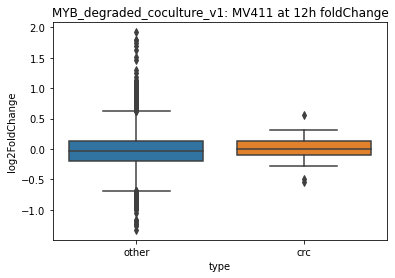

In [373]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title("{}: {} at 12h foldChange".format(project, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411_0_5_whiskers_baseMean.pdf


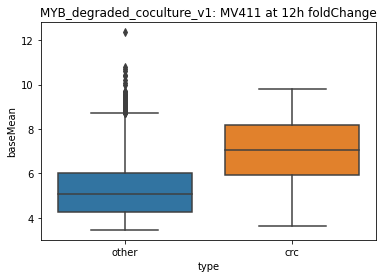

In [374]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title("{}: {} at 12h foldChange".format(project, var))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

#### ERCC normalized

In [375]:
# MV411 coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "VHL"
scaling="ERCCsamplewise"

In [376]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_coculture_v1_MV411_DMSO_VHL_ERCCsamplewise_0_5_deseq'

In [377]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [378]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-3.658482,0.107840,-3.746088,0.000000,0.002324
0.45,4.155569,-0.000000,0.457367,-0.097113,0.482500,0.999981
0.50,5.986865,-0.000000,0.525268,0.018393,0.539099,0.999981
0.75,26.952016,0.256588,1.284578,0.556827,0.781289,0.999981
1.00,5245.616335,5.013429,3.352475,5.234874,0.999981,0.999981


In [379]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-4.147321,0.093622,-4.504138,0.000000,0.008579
0.45,135.178786,-0.018687,0.165685,-0.130712,0.492344,0.999948
0.50,198.099655,0.002509,0.177853,-0.016155,0.537786,0.999948
0.75,924.046663,0.151564,0.386660,0.587616,0.771299,0.999948
1.00,174722.004540,8.923789,3.352475,5.011613,0.999984,0.999984


In [380]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crcs)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
0,4.248363,-0.254113,0.388118,0.654731,0.512641,0.999981,NAT1,NAT1,other
2,4.695967,-0.048395,0.302973,0.159735,0.873090,0.999981,AARS1,AARS1,other
4,3.715848,-0.285426,0.439031,0.650128,0.515610,0.999981,ABCA1,ABCA1,other
8,4.982447,0.281032,0.276810,-1.015252,0.309986,0.999981,ABCF1,ABCF1,other
9,5.013677,-0.318871,0.302358,1.054614,0.291602,0.999981,ABL1,ABL1,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411_ERCCsamplewise_0_5_whiskers_logfch.pdf


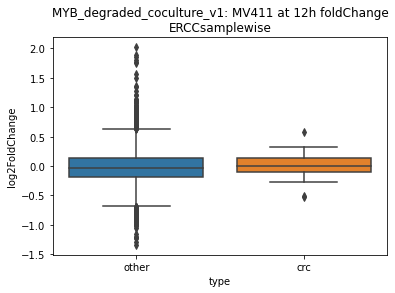

In [386]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411_ERCCsamplewise_0_5_whiskers_baseMean.pdf


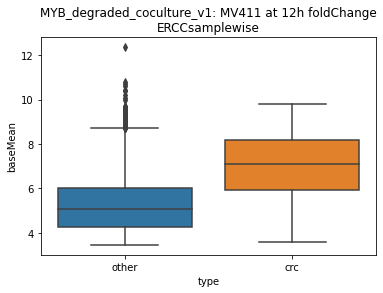

In [388]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

### MV411-MYB-dTAG coculture 12h

#### Unscaled

In [389]:
# MV411-MYB-dTAG coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
scaling=None

In [390]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_0_5_deseq'

In [391]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [392]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.093536,0.089636,-16.175168,0.000000,7.788422e-55
0.45,4.705055,-0.000000,0.437006,-0.109947,0.350176,7.652943e-01
0.50,6.750275,-0.000000,0.497189,0.021713,0.418141,8.076913e-01
0.75,30.656996,0.346780,1.227026,0.724193,0.746073,9.351082e-01
1.00,5522.372358,5.716403,3.352475,11.662649,0.999781,9.997811e-01


In [393]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.927525,0.058246,-27.405168,0.000000,1.744260e-235
0.45,134.466994,-0.014172,0.184516,-0.297612,0.242183,5.251292e-01
0.50,200.357667,0.024898,0.198064,-0.116234,0.300136,5.917710e-01
0.75,893.669955,0.317032,0.392192,0.931918,0.640370,8.460849e-01
1.00,161056.635406,6.255090,3.352475,33.059973,0.999970,9.999696e-01


In [394]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crcs)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
0,4.615468,0.136907,0.294880,-0.464283,0.642445,0.918784,NAT1,NAT1,other
2,4.555109,-0.034976,0.342941,0.101987,0.918767,0.984925,AARS1,AARS1,other
8,5.170085,0.301385,0.308459,-0.977066,0.328536,0.754550,ABCF1,ABCF1,other
9,5.183890,-0.512978,0.294060,1.744468,0.081077,0.440924,ABL1,ABL1,other
10,6.014401,0.446245,0.205016,-2.176634,0.029508,0.266112,ABL2,ABL2,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411-MYB-dTAG_0_5_whiskers_logfch.pdf


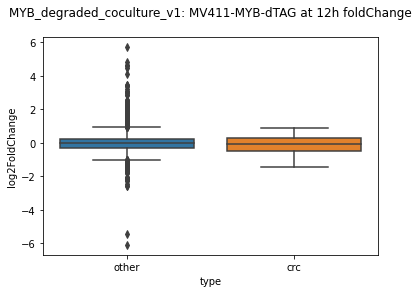

In [395]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411-MYB-dTAG_0_5_whiskers_baseMean.pdf


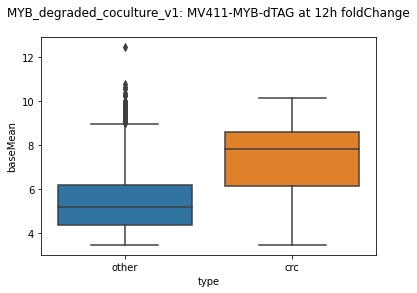

In [396]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

#### ERCC normalized

In [397]:
# MV411 coculture 12h
version = "v1"
var_name = "experiment"
var = "MV411-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
scaling="ERCCsamplewise"

In [398]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_coculture_v1_MV411-MYB-dTAG_DMSO_VHL_ERCCsamplewise_0_5_deseq'

In [399]:
# read in DESeq outputs
resGene_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [400]:
resGene_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-6.344375,0.140359,-12.923865,0.000000,2.867185e-34
0.45,4.338560,-0.220393,0.465350,0.297420,0.324657,6.294117e-01
0.50,6.233754,-0.141782,0.525477,0.391275,0.388521,6.726570e-01
0.75,28.244047,0.127190,1.263411,1.167873,0.724765,8.590730e-01
1.00,4990.195295,5.529439,3.352475,11.802923,0.999949,9.999486e-01


In [401]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-7.172893,0.093880,-20.638872,0.000000,3.354201e-146
0.45,124.505715,-0.231016,0.238848,0.551670,0.202700,4.281469e-01
0.50,184.590242,-0.192501,0.253573,0.718903,0.255561,4.843524e-01
0.75,829.584857,0.100027,0.429537,1.681996,0.585598,7.659392e-01
1.00,146403.679292,6.018034,3.352475,26.119422,0.999917,9.999172e-01


In [402]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene_tc[resGene_tc.baseMean>10]
res = res.assign(baseMean = np.log2(1+res["baseMean"]))
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crcs)]
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
0,4.480184,-0.115703,0.316543,0.365521,0.714723,0.892517,NAT1,NAT1,other
2,4.443587,-0.274597,0.370816,0.740520,0.458984,0.753728,AARS1,AARS1,other
8,5.025468,0.044529,0.316200,-0.140826,0.888007,0.958358,ABCF1,ABCF1,other
9,5.100178,-0.731124,0.340668,2.146149,0.031861,0.219614,ABL1,ABL1,other
10,5.877073,0.215359,0.241580,-0.891460,0.372683,0.696905,ABL2,ABL2,other


Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411-MYB-dTAG_ERCCsamplewise_0_5_whiskers_logfch.pdf


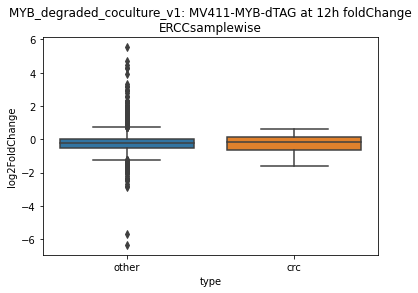

In [403]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_logfch.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax = sns.boxplot(data=res,x="type",y="log2FoldChange").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/slamseq_MYB_degraded_coculture_v1/plots/MYB_degraded_coculture_v1_MV411-MYB-dTAG_ERCCsamplewise_0_5_whiskers_baseMean.pdf


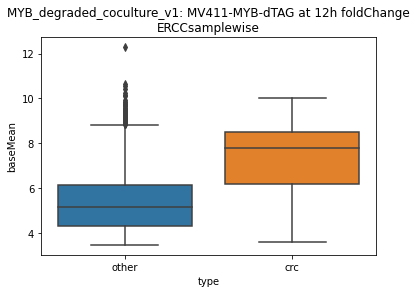

In [404]:
fig_file = "../results/slamseq_{0}/plots/{0}_{1}_whiskers_baseMean.pdf".format(
    project, "_".join(filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

ax =sns.boxplot(data=res,x="type",y="baseMean").set_title(
    "{}: {} at 12h foldChange\n{}".format(project, var, "".join(filter(None, [scaling]))))
ax.figure.savefig(fig_file, bbox_inches="tight")
print("Saved box and whisker plot to: {}".format(fig_file))